# Introduction

## Data description

Before we dive into parsing and plotting the data, let's first discuss what our data represents.  
We have two main datasets:
1. **E-mail network** (Directed temporal graph, nodes are people and edges are emails sent from employee *A* to employee *B* at timestamp *t*)
2. **Stack Exchange network** (Directed temporal graph, nodes are users and edges are replies/comments from user *A* to user *B* at timestamp *t*)

Both of them are constructed from 4 subnetworks each: 
- E-mail network: *Department 1, Department 2, Department 3, Department 4*
- Stack Exchange network: *Ask Ubuntu, Math Overflow, Stack Overflow, Super User*

## Main objective
Our main objective is to assign **subgraphs** (ex. graph constructed from mails sent within a 3 hour period) to one of the **subnetworks** (ex. Dept. 1, Dept. 2, Dept. 3, Dept. 4). The networks as a whole will be called **datasets**.  

This problem is known as **classification**.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

In [2]:
jtplot.style(theme='onedork')
jtplot.style(context='talk', fscale=1.4, spines=False, gridlines='--')
jtplot.style(ticks=True, grid=False, figsize=(6, 4.5))

# Data dive

In [3]:
df_email_dept_1 = pd.read_csv('data/original/email/dept_1.csv', delim_whitespace=True, header=None, names=['from', 'to', 'timestamp'])
df_email_dept_1.head()

,from,to,timestamp
0,151,280,30281
1,176,225,30899
2,69,223,32305
3,28,285,32748
4,26,225,33383


We see that our dataset consists of rows that represent timestamped edges.  
Let's repeat for the rest of the datasets.

In [4]:
df_email_dept_2 = pd.read_csv('data/original/email/dept_2.csv', delim_whitespace=True, header=None, names=['from', 'to', 'timestamp'])
df_email_dept_3 = pd.read_csv('data/original/email/dept_3.csv', delim_whitespace=True, header=None, names=['from', 'to', 'timestamp'])
df_email_dept_4 = pd.read_csv('data/original/email/dept_4.csv', delim_whitespace=True, header=None, names=['from', 'to', 'timestamp'])

In [5]:
df_sx_askubuntu = pd.read_csv('data/original/sx/askubuntu.csv', delim_whitespace=True, header=None, names=['from', 'to', 'timestamp'])
df_sx_mathoverflow = pd.read_csv('data/original/sx/mathoverflow.csv', delim_whitespace=True, header=None, names=['from', 'to', 'timestamp'])
df_sx_stackoverflow = pd.read_csv('data/original/sx/stackoverflow.csv', delim_whitespace=True, header=None, names=['from', 'to', 'timestamp'])
df_sx_superuser = pd.read_csv('data/original/sx/superuser.csv', delim_whitespace=True, header=None, names=['from', 'to', 'timestamp'])

### Let's focus on the distribution of the sizes of the dataset

In [6]:
email_dataset_sizes = [len(df_email_dept_1), len(df_email_dept_2), len(df_email_dept_3), len(df_email_dept_4)]
sx_dataset_sizes = [len(df_sx_askubuntu), len(df_sx_mathoverflow), len(df_sx_stackoverflow), len(df_sx_superuser)]

In [7]:
print('Email dataset sizes: ', email_dataset_sizes)
print('Stack exchange dataset sizes: ', sx_dataset_sizes)

Email dataset sizes:  [61046, 46772, 12216, 48141]
Stack exchange dataset sizes:  [964437, 506550, 63497050, 1443339]


### Let's plot these to get more intuition of the imbalances

In [8]:
email_dataset_names = ['Dept. 1', 'Dept. 2', 'Dept. 3', 'Dept. 4']
sx_dataset_names = ['Ask Ubuntu', 'Math Overflow', 'Stack Overflow', 'Super User']

email_x_pos = np.arange(len(email_dataset_names))
sx_x_pos = np.arange(len(sx_dataset_names))

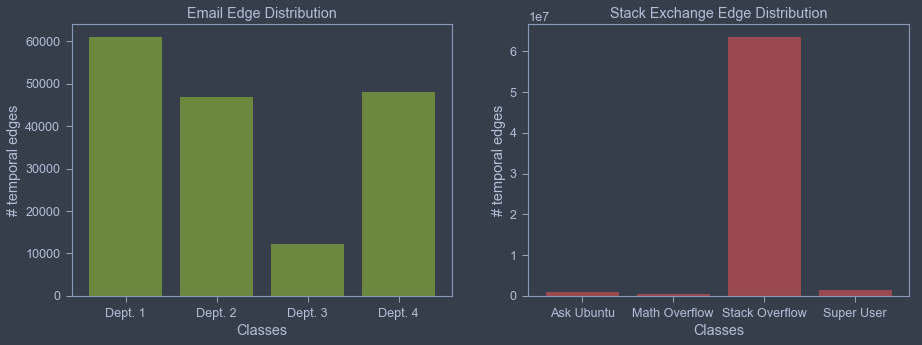

In [9]:
fig = plt.figure(figsize=(15,5))

plt.subplot(121)
plt.bar(email_x_pos, email_dataset_sizes, align='center', alpha=0.7, color='g')
plt.xticks(email_x_pos, email_dataset_names)
plt.xlabel('Classes')
plt.ylabel('# temporal edges')
plt.title('Email Edge Distribution')

plt.subplot(122)
plt.bar(sx_x_pos, sx_dataset_sizes, align='center', alpha=0.7, color='r')
plt.xticks(sx_x_pos, sx_dataset_names)
plt.xlabel('Classes')
plt.ylabel('# temporal edges')
plt.title('Stack Exchange Edge Distribution')
    
plt.show()

## Overview
First off, let's address the elephant in the room. The **StackOverflow** dataset is way bigger than any of the other datasets.  

If this was a standard machine learning problem, it would be a disaster - we shouldn't allow certain classes to have more samples than the others. All classes should be represented uniformly.  However, the term sample is highly relative. 

If we were to somehow, magically, classify each edge to a certain subnetwork, then this non-uniformity wouldn't be appropriate. But, that's not what we are trying to achieve.  

As we stated in the main objective, we would like to classify a certain network constructed over a small period of time to one of the subnetworks. That network could have 10 edges or 1000 for all we know.  
So, we don't treat the timestamped edges (rows in the original input files) as samples for our machine learning models, but the very same thing we are trying to classify - graphs formed over a small period of time. This means that we need to generate enough subgraphs from the timestamped edges to train a machine learning model.

We will go over this in much more detail in the following notebooks, but for now, we only need to make sure that the datasets begin and end around the same time and that each of them are sorted by the timestamp column.

### Sorting the Stack Exchange datasets by the timestamp value

In [10]:
df_sx_superuser.sort_values(by=['timestamp'], inplace=True)
df_sx_askubuntu.sort_values(by=['timestamp'], inplace=True)
df_sx_stackoverflow.sort_values(by=['timestamp'], inplace=True)
df_sx_mathoverflow.sort_values(by=['timestamp'], inplace=True)

### Trimming the Stack Exchange datasets
From the Stack Exchange dataset, the Ask Ubuntu subnetwork starts regularly a few months later than the rest of the subnetworks.  
This means that we have to trim the other three from the beginning so that they start at the same period of time.  They all end on the same day.

In [11]:
ts = 1280369730

df_sx_superuser_trimmed = df_sx_superuser[df_sx_superuser['timestamp'] >= ts]
df_sx_askubuntu_trimmed = df_sx_askubuntu[df_sx_askubuntu['timestamp'] >= ts]
df_sx_mathoverflow_trimmed = df_sx_mathoverflow[df_sx_mathoverflow['timestamp'] >= ts]
df_sx_stackoverflow_trimmed = df_sx_stackoverflow[df_sx_stackoverflow['timestamp'] >= ts]

### Sorting the E-mail datasets by the timestamp value

In [12]:
df_email_dept_1.sort_values(by=['timestamp'], inplace=True) 
df_email_dept_2.sort_values(by=['timestamp'], inplace=True) 
df_email_dept_3.sort_values(by=['timestamp'], inplace=True) 
df_email_dept_4.sort_values(by=['timestamp'], inplace=True) 

### Trimming the E-mail datasets
There's no need to trim, all of the datasets are roughly in the same period of time

### Let's save everything and wrap up

In [13]:
df_email_dept_1.to_csv('data/formatted/email/dept_1.csv', sep=' ', index=False)
df_email_dept_2.to_csv('data/formatted/email/dept_2.csv', sep=' ', index=False)
df_email_dept_3.to_csv('data/formatted/email/dept_3.csv', sep=' ', index=False)
df_email_dept_4.to_csv('data/formatted/email/dept_4.csv', sep=' ', index=False)

In [14]:
df_sx_superuser_trimmed.to_csv('data/formatted/sx/superuser.csv', sep=' ', index=False)
df_sx_askubuntu_trimmed.to_csv('data/formatted/sx/askubuntu.csv', sep=' ', index=False)
df_sx_mathoverflow_trimmed.to_csv('data/formatted/sx/mathoverflow.csv', sep=' ', index=False)
df_sx_stackoverflow_trimmed.to_csv('data/formatted/sx/stackoverflow.csv', sep=' ', index=False)